London Overground


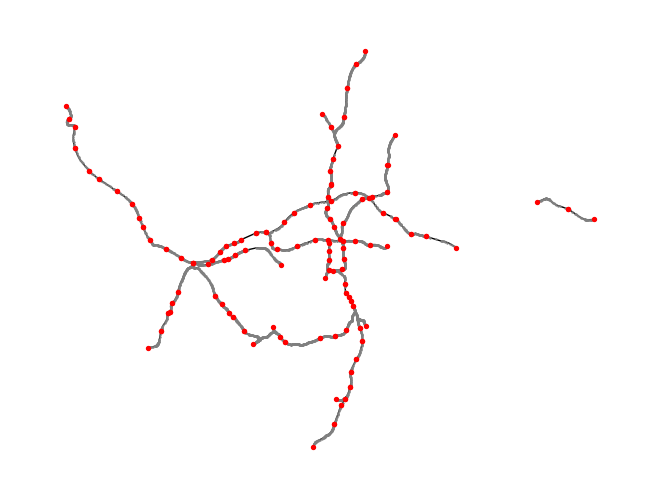

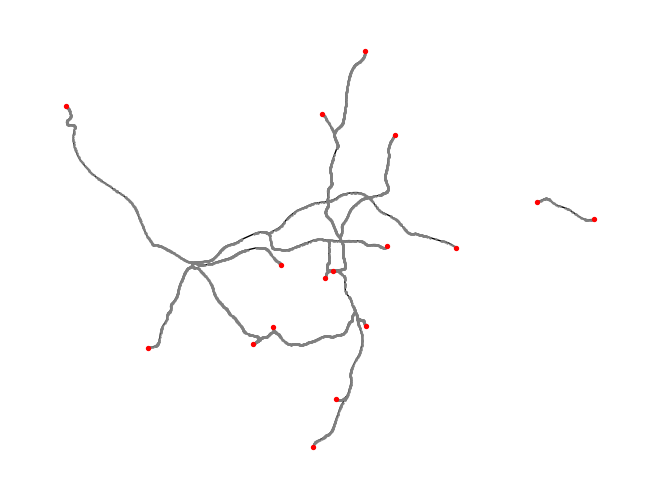

3
Jubilee


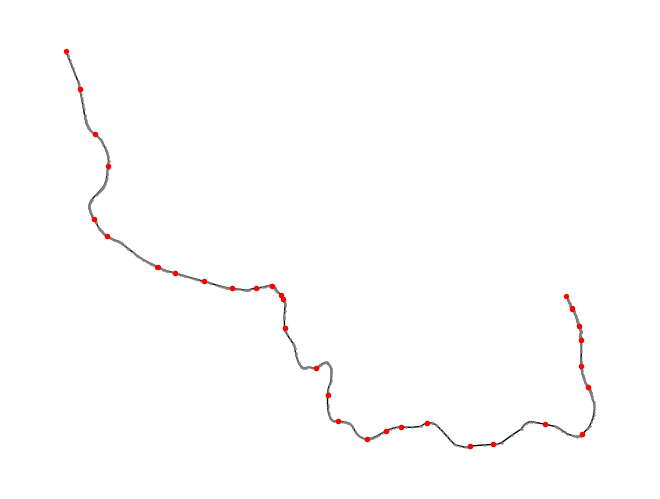

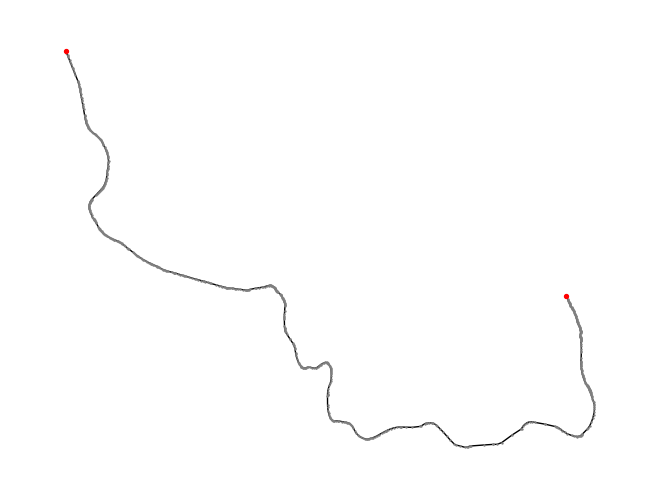

1
Piccadilly


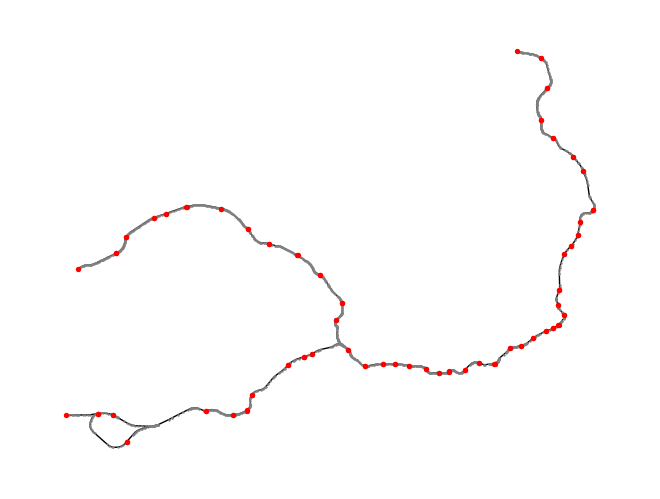

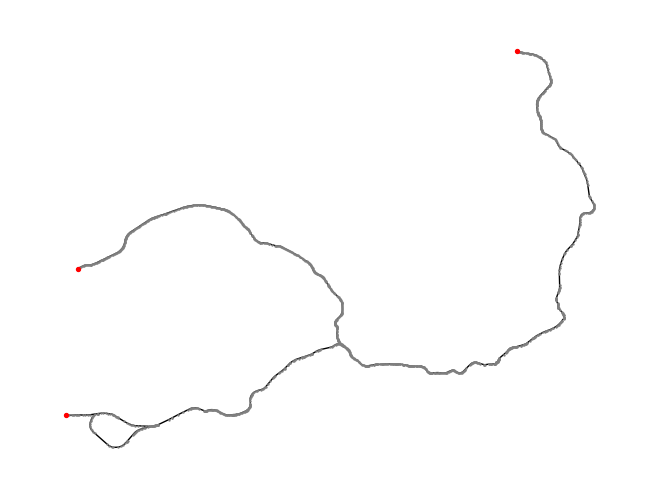

1
Circle


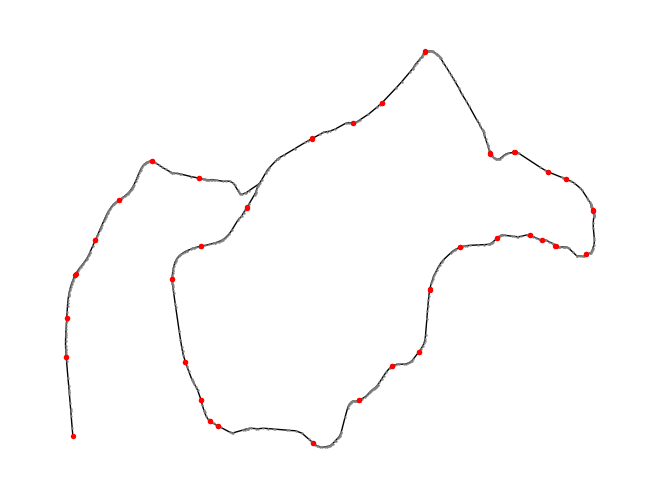

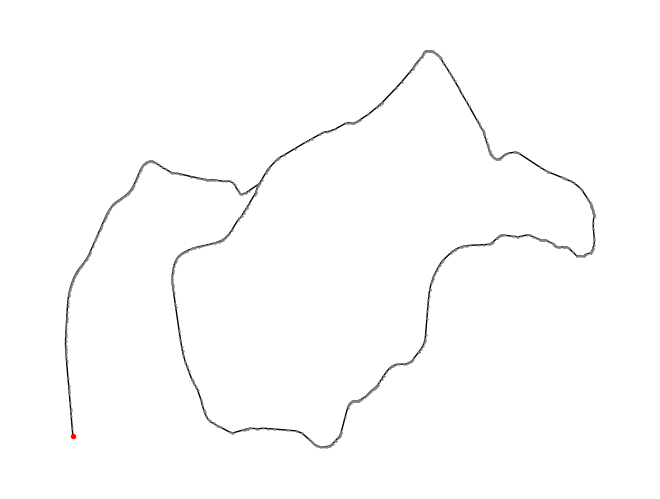

1
Northern


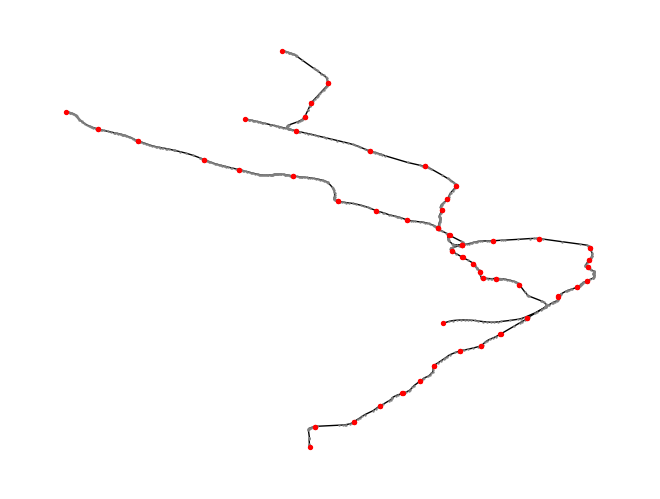

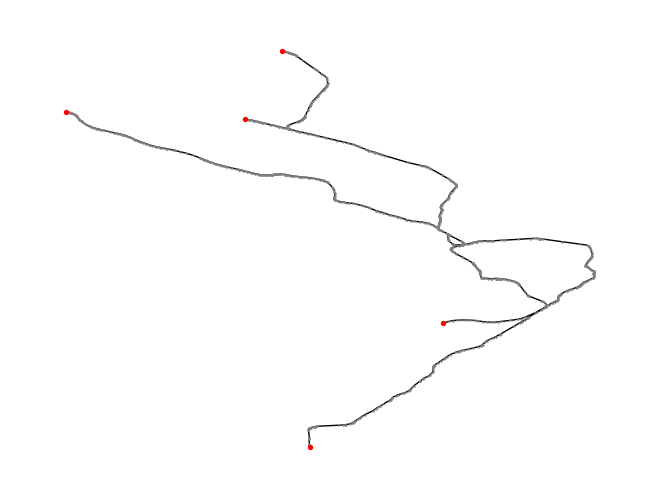

1
TfL Rail


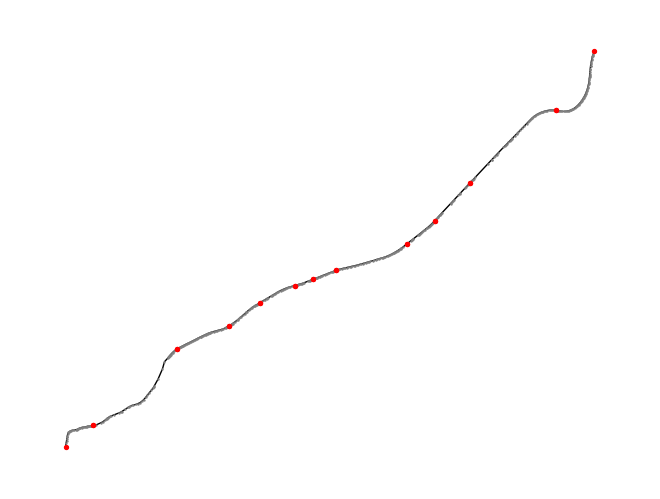

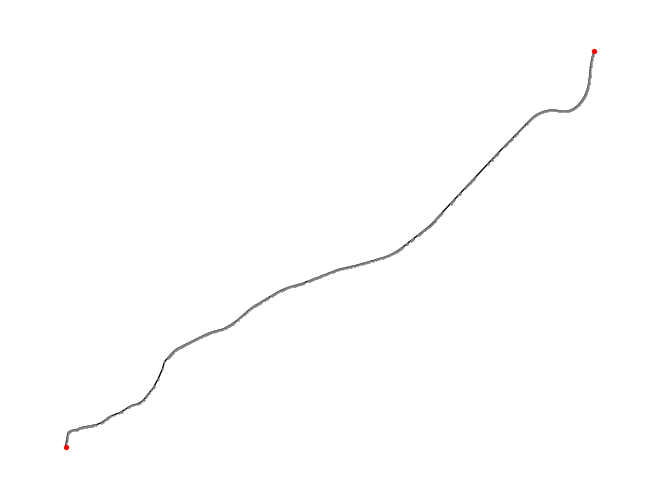

1
DLR


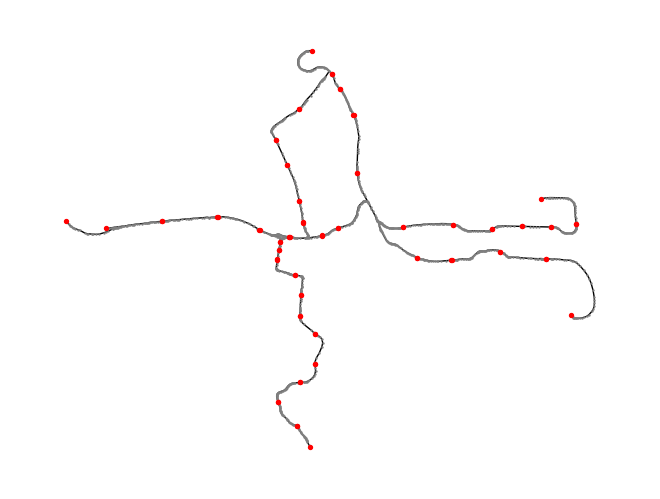

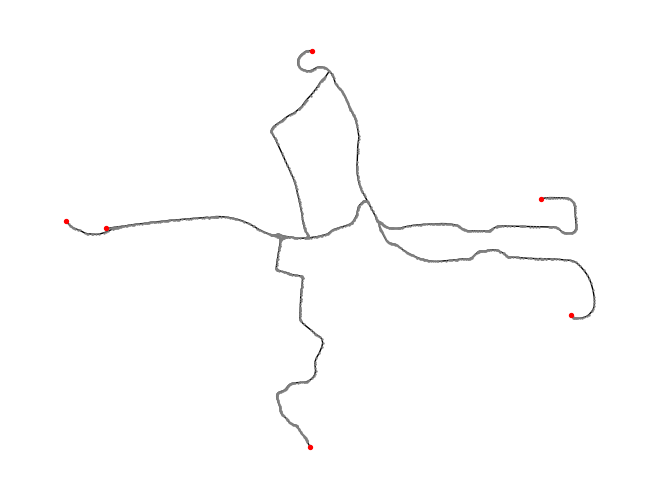

1
Victoria


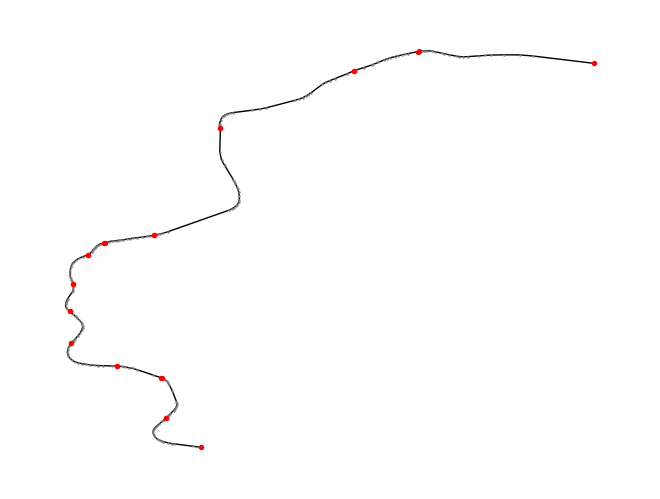

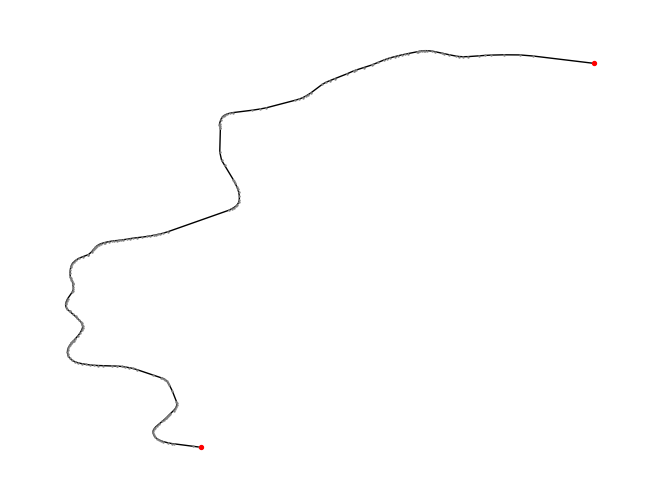

1
Waterloo & City


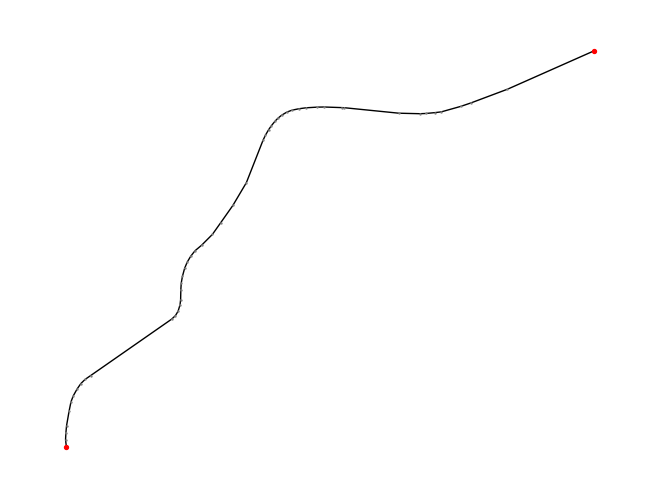

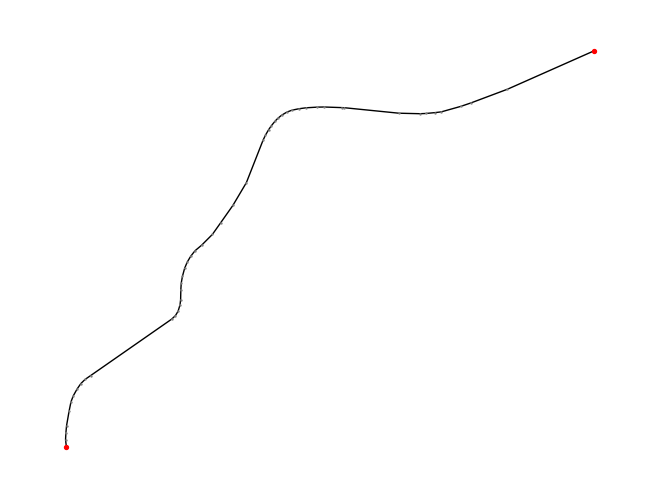

1
Hammersmith & City


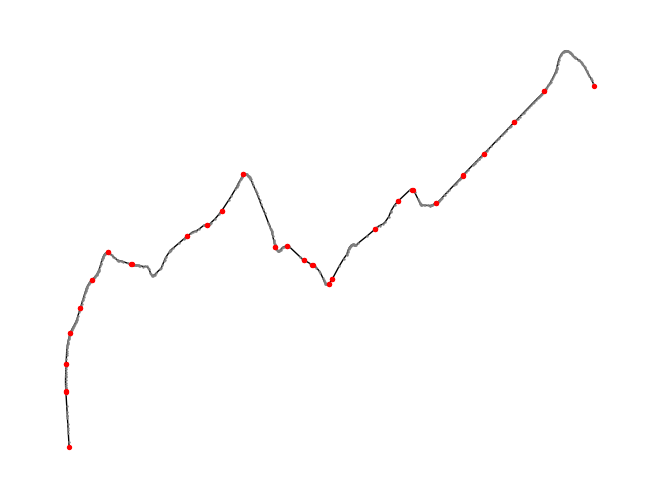

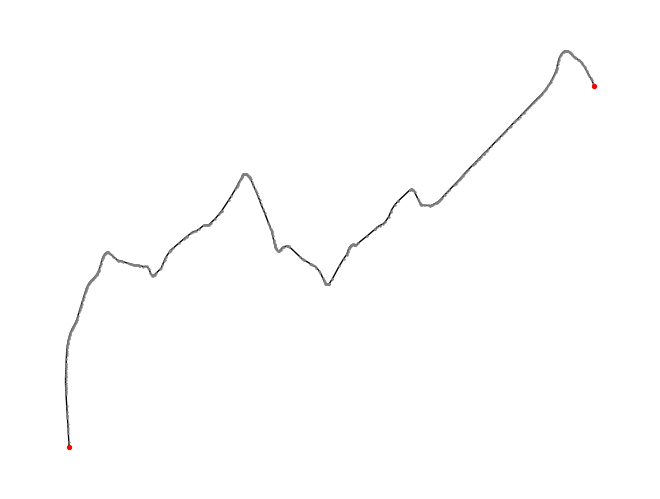

1
District


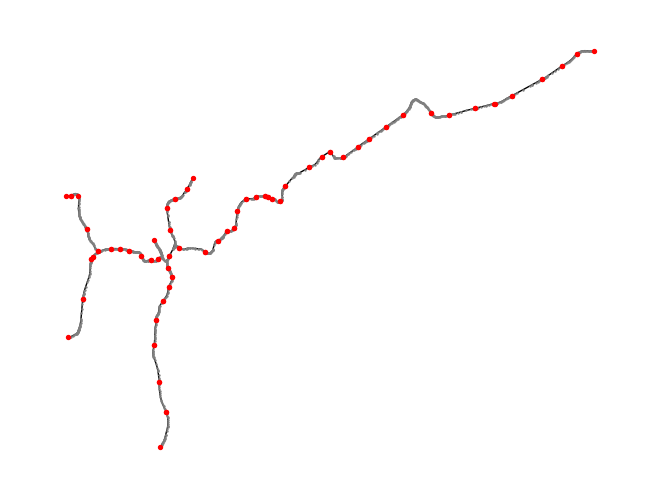

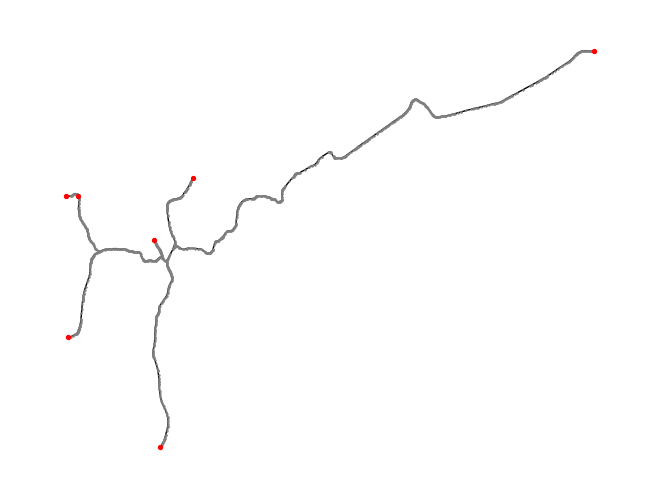

1
Bakerloo


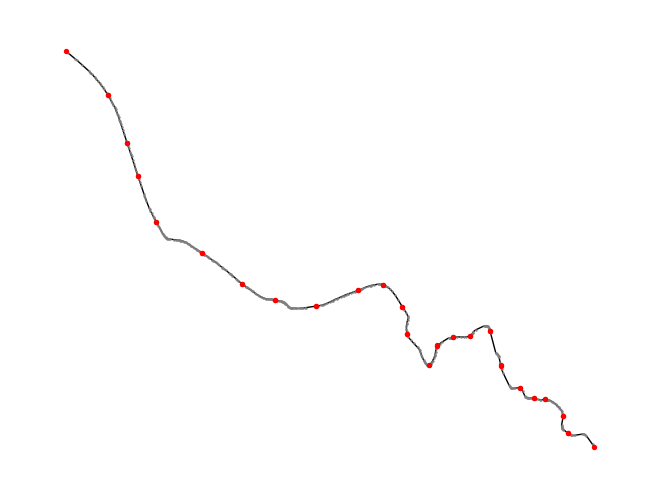

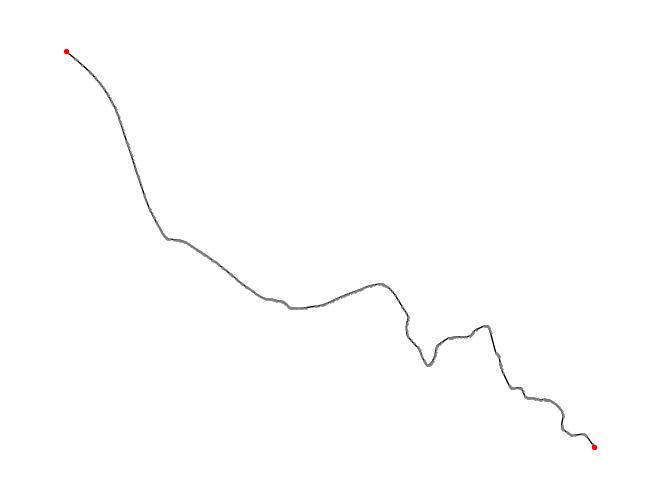

1
Metropolitan


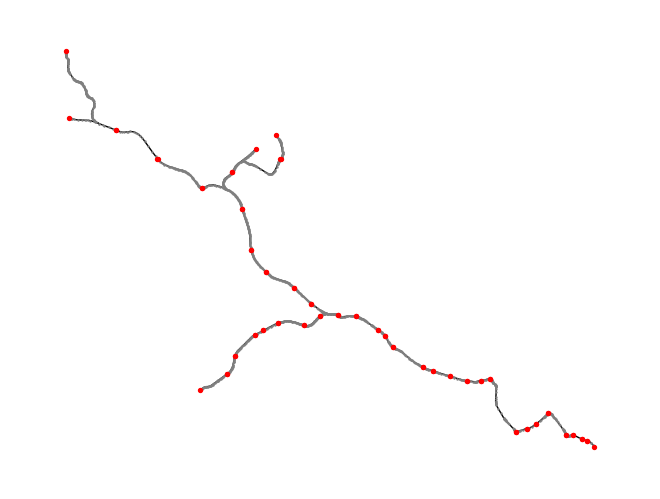

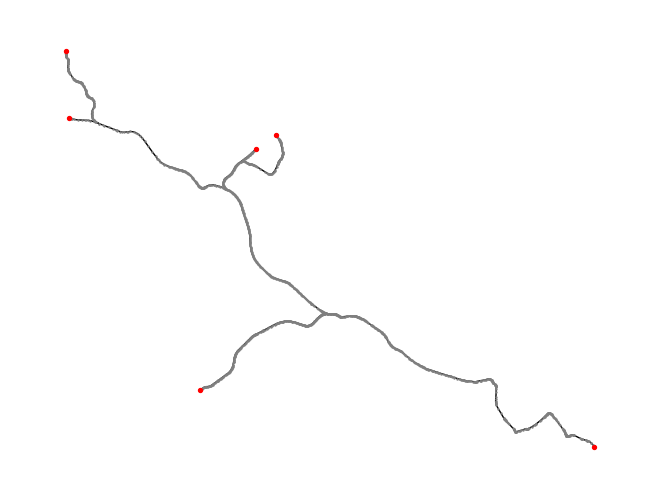

1
Central


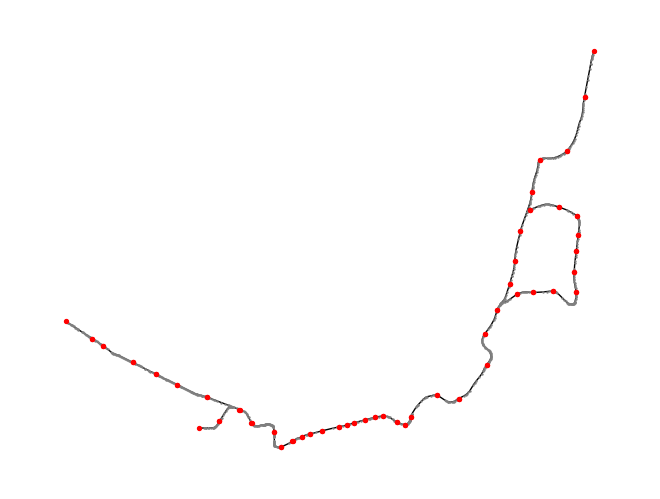

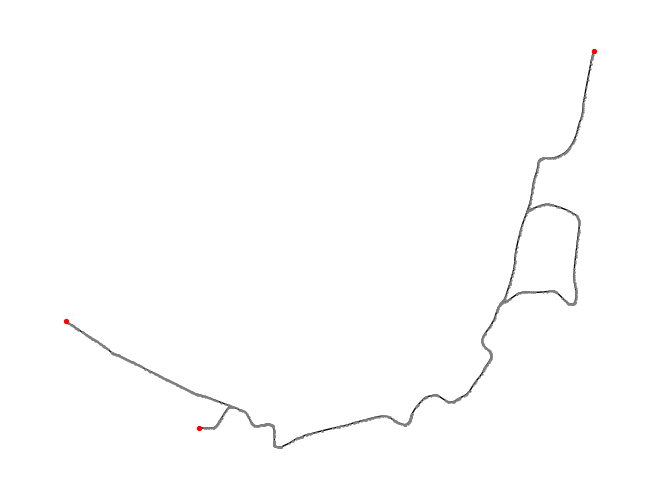

1


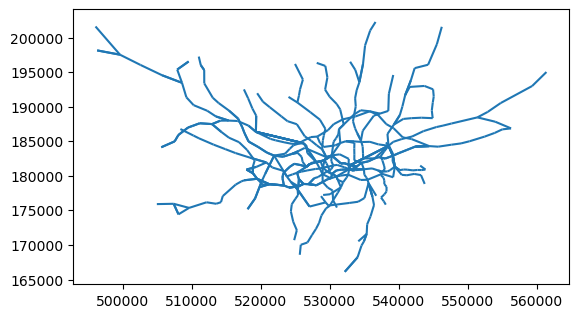

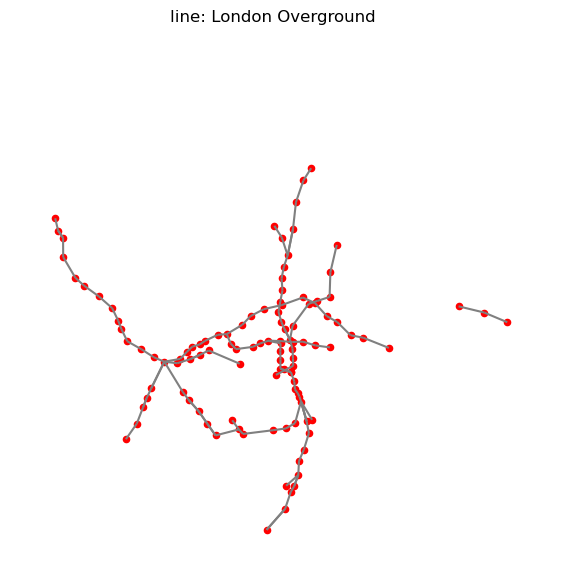

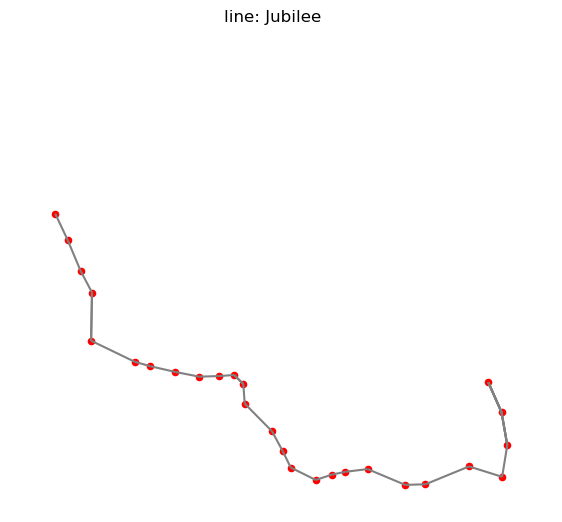

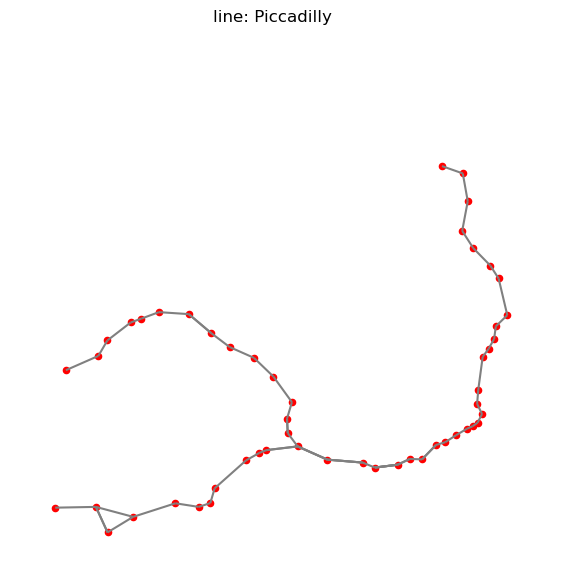

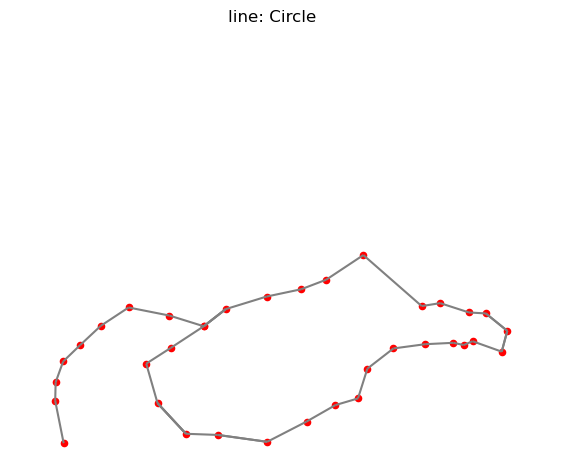

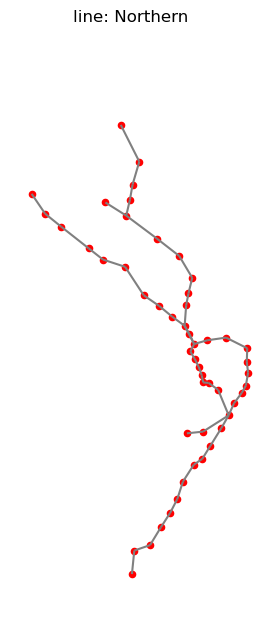

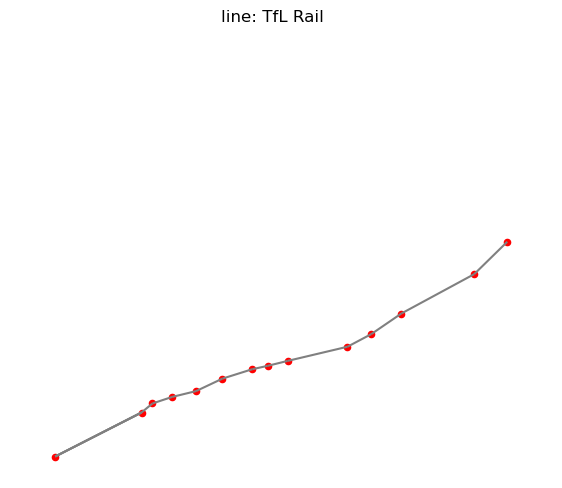

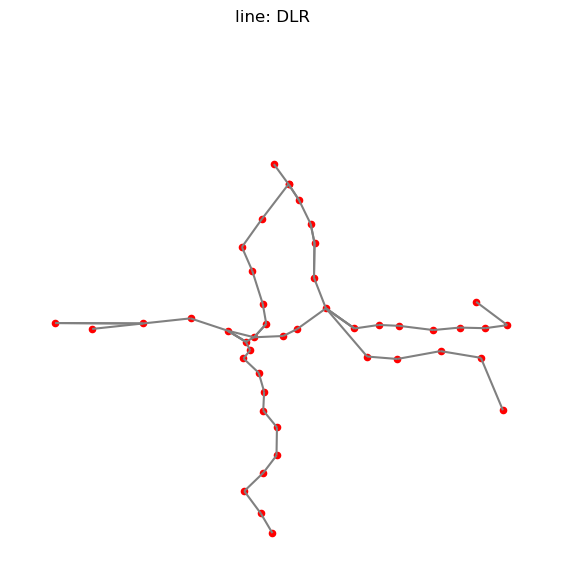

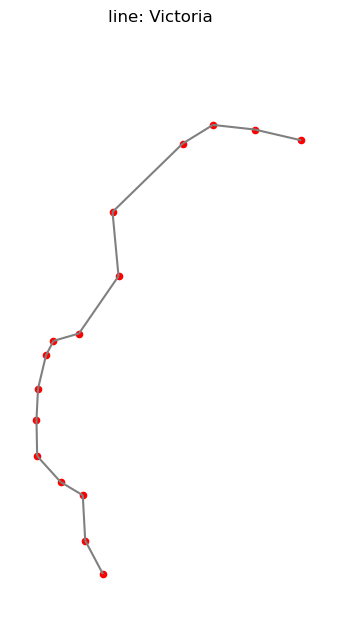

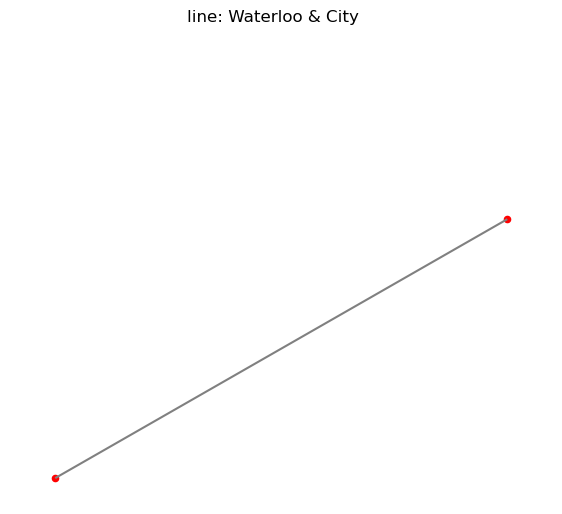

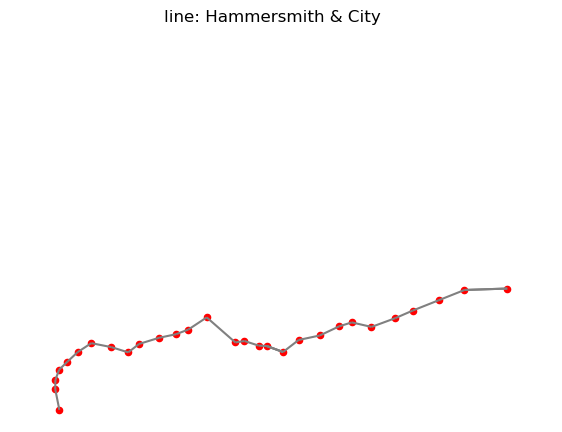

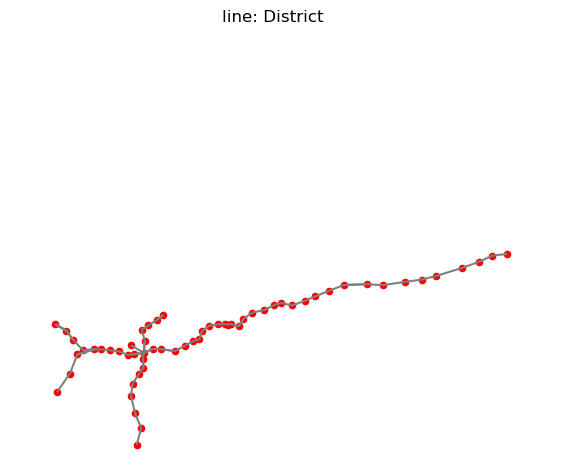

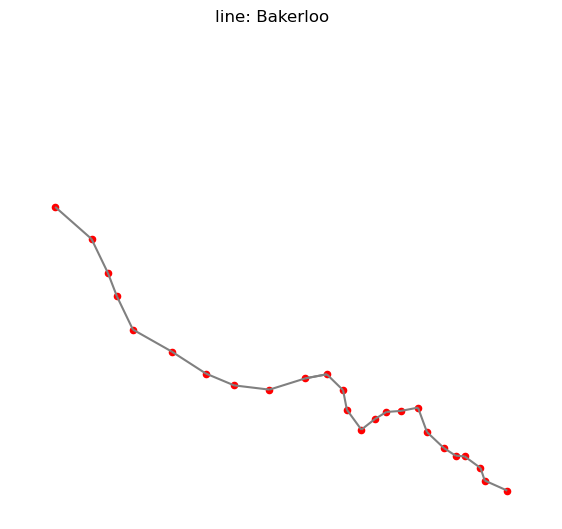

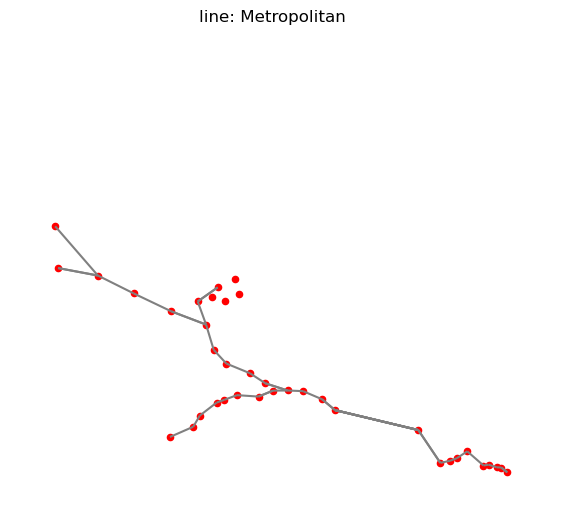

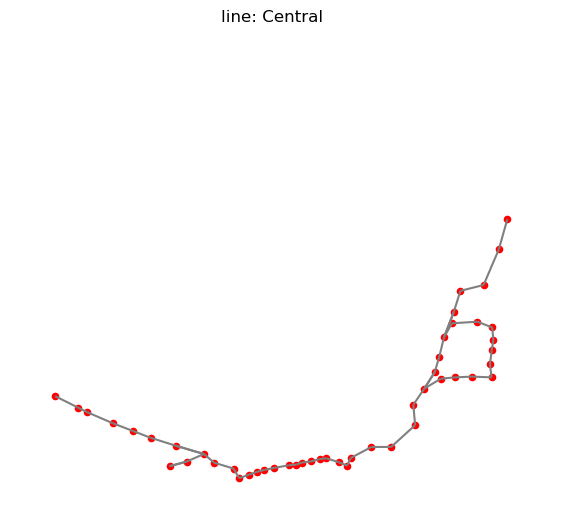

{'Circle', 'Waterloo & City', 'Hammersmith & City', 'District', 'Northern', 'Bakerloo', 'TfL Rail', 'London Overground', 'Jubilee', 'Metropolitan', 'Central', 'DLR', 'Victoria', 'Piccadilly'}


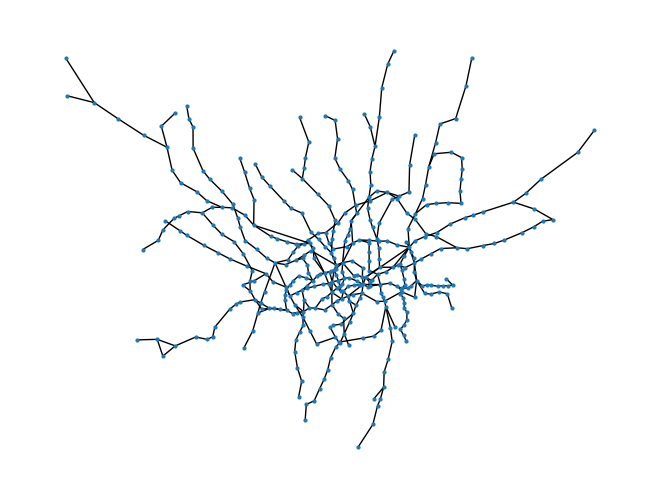

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Earl's Court,6
Canning Town,6
Green Park,6
Waterloo,6
Oxford Circus,6
Liverpool Street,6


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import geopandas as gpd
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import matplotlib.pyplot as plt
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)
    #set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()
#save position to graph
nx.set_node_attributes(G, pos, 'coords')
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()
df.sort_values('degree', ascending =False).head(20)

In [2]:
london_OD = pd.read_csv('london_flows.csv')
london_OD.info()
#check that our OD data and network data match
OD_names = set(london_OD.station_origin.unique())
network_names = set([n for n in G.nodes()])
# is there any difference
network_names.symmetric_difference(OD_names)
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter
london_OD_new = london_OD[~london_OD.station_origin.isin(_filter)]
london_OD_new = london_OD[~london_OD.station_destination.isin(_filter)]
london_OD_new.rename(columns={'station_origin':'Orig','station_destination':'Dest'}, inplace=True)
london_OD_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


,Orig,Dest,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [3]:
data2 = pd.read_csv('data2.csv')
# Merge 'A_change' from data2 into data
london_OD_new = london_OD_new.merge(data2[['Orig', 'Dest', 'SA_change']], on=['Orig', 'Dest'], how='left', suffixes=('', '_y'))
london_OD_new = london_OD_new.merge(data2[['Orig', 'Dest', 'SB1_change']], on=['Orig', 'Dest'], how='left', suffixes=('', '_y'))
london_OD_new = london_OD_new.merge(data2[['Orig', 'Dest', 'SB2_change']], on=['Orig', 'Dest'], how='left', suffixes=('', '_y'))
# Fill NaN values in 'A_change' with 0 for rows in 'data' that do not have a corresponding match in 'data2'
london_OD_new['SA_change'].fillna(0, inplace=True)
london_OD_new['SB1_change'].fillna(0, inplace=True)
london_OD_new['SB2_change'].fillna(0, inplace=True)
# Optionally, if there's a need to clean up if any additional columns were accidentally created during merge (depends on column names):
# data.drop(columns=[col for col in data.columns if '_y' in col], inplace=True)
# Show the updated DataFrame
london_OD_new

,Orig,Dest,flows,population,jobs,distance,SA_change,SB1_change,SB2_change
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,5.0,-23.0,-72.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,0.0,-1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,0.0,-2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,-36.0,-10.0,-68.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,4.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...
61609,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.0,-26.0,-92.0
61610,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,25.0,16.0,-118.0
61611,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,3.0,0.0,-21.0
61612,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,10.0,45.0,223.0


In [4]:
#create a dictionary to store flows for all edges
SA_change = {(u,v): 0 for u,v in G.edges()}
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.Orig
    target = row.Dest
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            SA_change[(u,v)] += row.SA_change
        except:
            SA_change[(v,u)] += row.SA_change
#set this as a network attribute
nx.set_edge_attributes(G, SA_change, 'SA_change')

In [5]:
from matplotlib.colors import Normalize

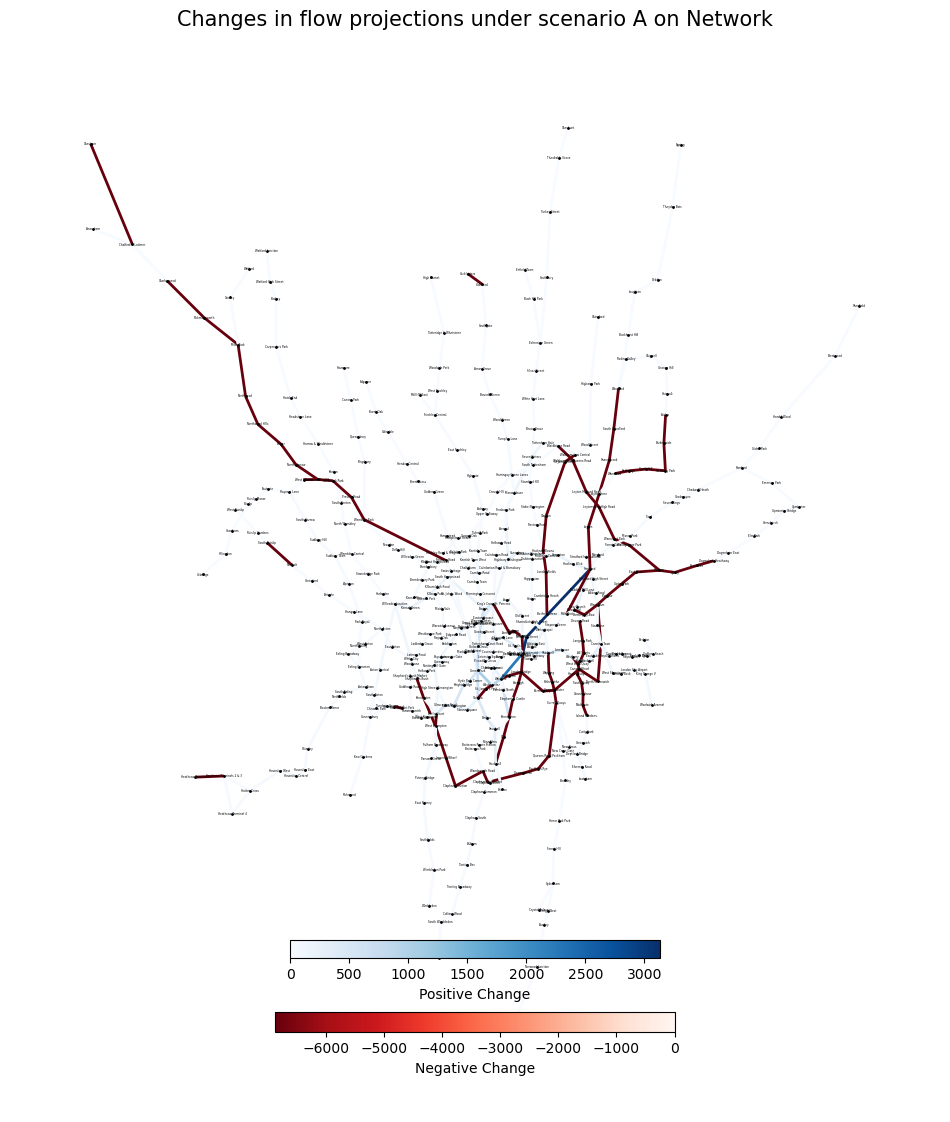

In [6]:
# 从最小到最大的颜色映射
SA_change_values = np.array(list(SA_change.values()))
max_change = np.max(SA_change_values)
min_change = np.min(SA_change_values)
positive_norm = Normalize(0, max_change)
negative_norm = Normalize(min_change, 0)

# 使用两个不同的颜色映射
positive_cmap = plt.cm.Blues
negative_cmap = plt.cm.Reds_r 

# 计算边的颜色
SA_change_color = []
for _, _, data in G.edges(data=True):
    value = data['SA_change']
    if value >= 0:
        color = positive_cmap(positive_norm(value))
    else:
        color = negative_cmap(-negative_norm(value))  # 取反，因为负数的norm计算可能需要调整
    SA_change_color.append(color)

# 边的宽度
SA_change_width = [2 for _ in G.edges()]

# 绘制网络图
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color=SA_change_color, width=SA_change_width)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=1)
nx.draw_networkx_labels(G, pos, font_size=2, font_color='black')  # 显示节点名称
# 设置颜色条
positive_sm = plt.cm.ScalarMappable(cmap=positive_cmap, norm=positive_norm)
positive_sm.set_array([])
negative_sm = plt.cm.ScalarMappable(cmap=negative_cmap, norm=negative_norm)
negative_sm.set_array([])

# 创建一个颜色条
cbar_pos = plt.colorbar(positive_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_neg = plt.colorbar(negative_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_pos.set_label('Positive Change')
cbar_neg.set_label('Negative Change')

plt.axis('off')
plt.title("Changes in flow projections under scenario A on Network", fontsize=15)
plt.show()

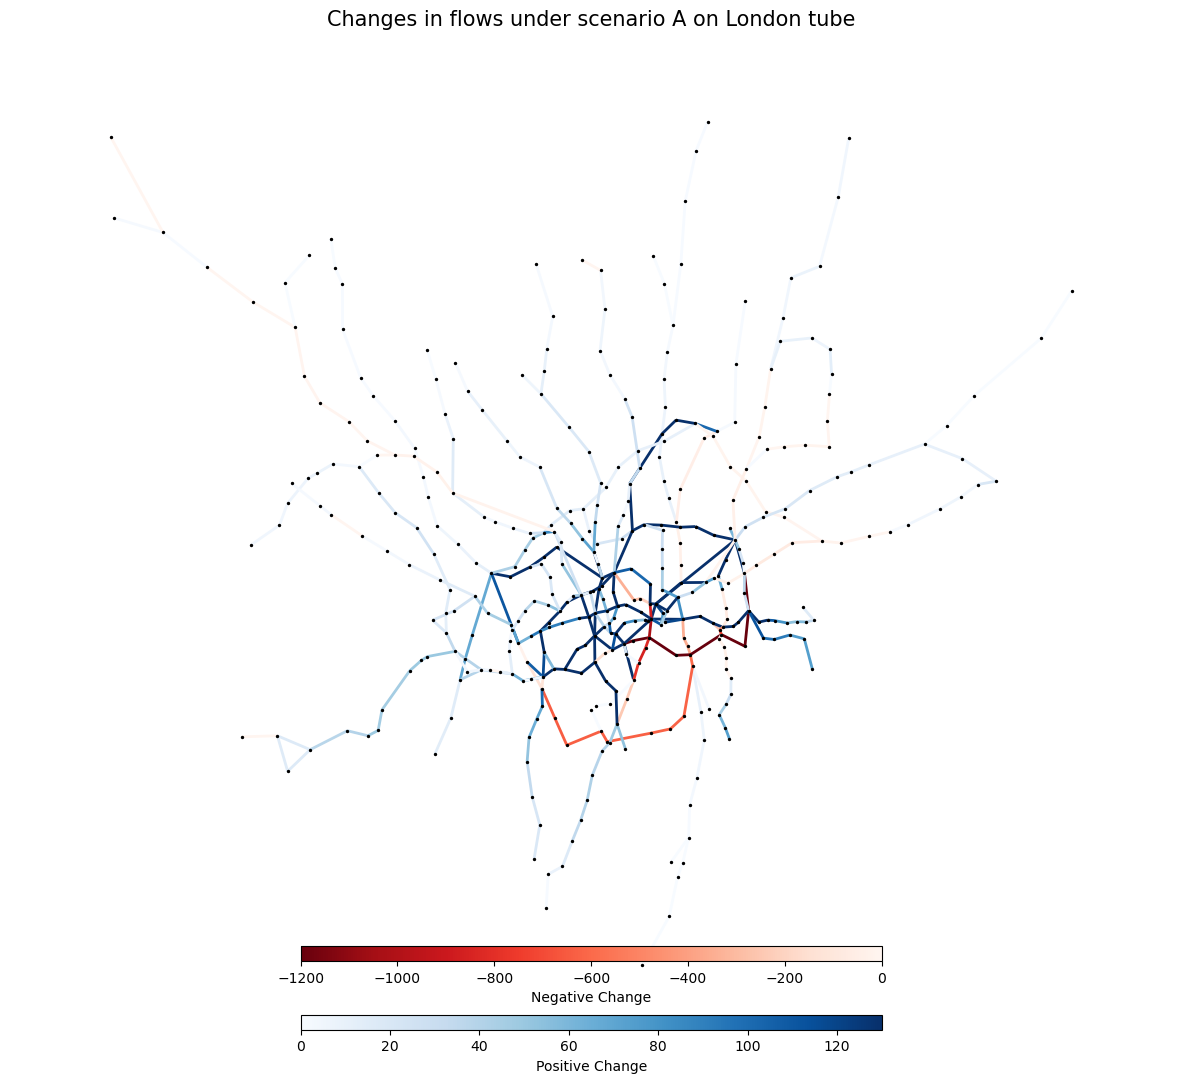

In [34]:
# 现有SA_change值的范围设定
max_change = 130  # 实际最大值
min_change = -1200  # 实际最小值

# 将颜色正规化到给定的最大值和最小值
positive_norm = Normalize(0, max_change)
negative_norm = Normalize(min_change, 0)

# 使用两个不同的颜色映射
positive_cmap = plt.cm.Blues
negative_cmap = plt.cm.Reds_r 

# 计算边的颜色
SA_change_color = []
for _, _, data in G.edges(data=True):
    value = data['SA_change']
    if value >= 0:
        color = positive_cmap(positive_norm(value))
    else:
        # 这里我们直接使用value而不是-value，因为Normalize已经处理了负值
        color = negative_cmap(negative_norm(value))
    SA_change_color.append(color)

# 边的宽度，可以根据SA_change的值进行调整以更好地反映权重
SA_change_width = [2 for _ in G.edges()]

# 绘制网络图
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_networkx_edges(G, pos, edge_color=SA_change_color, width=SA_change_width)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=2)
#nx.draw_networkx_labels(G, pos, font_size=20, font_color='black')  # 调整字体大小和颜色以便阅读

# 设置颜色条
positive_sm = plt.cm.ScalarMappable(cmap=positive_cmap, norm=positive_norm)
positive_sm.set_array([])
negative_sm = plt.cm.ScalarMappable(cmap=negative_cmap, norm=negative_norm)
negative_sm.set_array([])

# 创建并定位颜色条
cbar_pos = plt.colorbar(positive_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.08, aspect=40)
cbar_neg = plt.colorbar(negative_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.10, aspect=40)

# 为颜色条设置标签
cbar_pos.set_label('Positive Change')
cbar_neg.set_label('Negative Change')

# 调整颜色条的位置和大小等属性以更好地呈现
plt.axis('off')
plt.title("Changes in flows under scenario A on London tube", fontsize=15)
plt.savefig('figure/Figure 13. Spatial distribution of flow changes under scenario A.png')
plt.show()

In [14]:
#create a dictionary to store flows for all edges
SB1_change = {(u,v): 0 for u,v in G.edges()}
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.Orig
    target = row.Dest
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            SB1_change[(u,v)] += row.SB1_change
        except:
            SB1_change[(v,u)] += row.SB1_change
#set this as a network attribute
nx.set_edge_attributes(G, SB1_change, 'SB1_change')

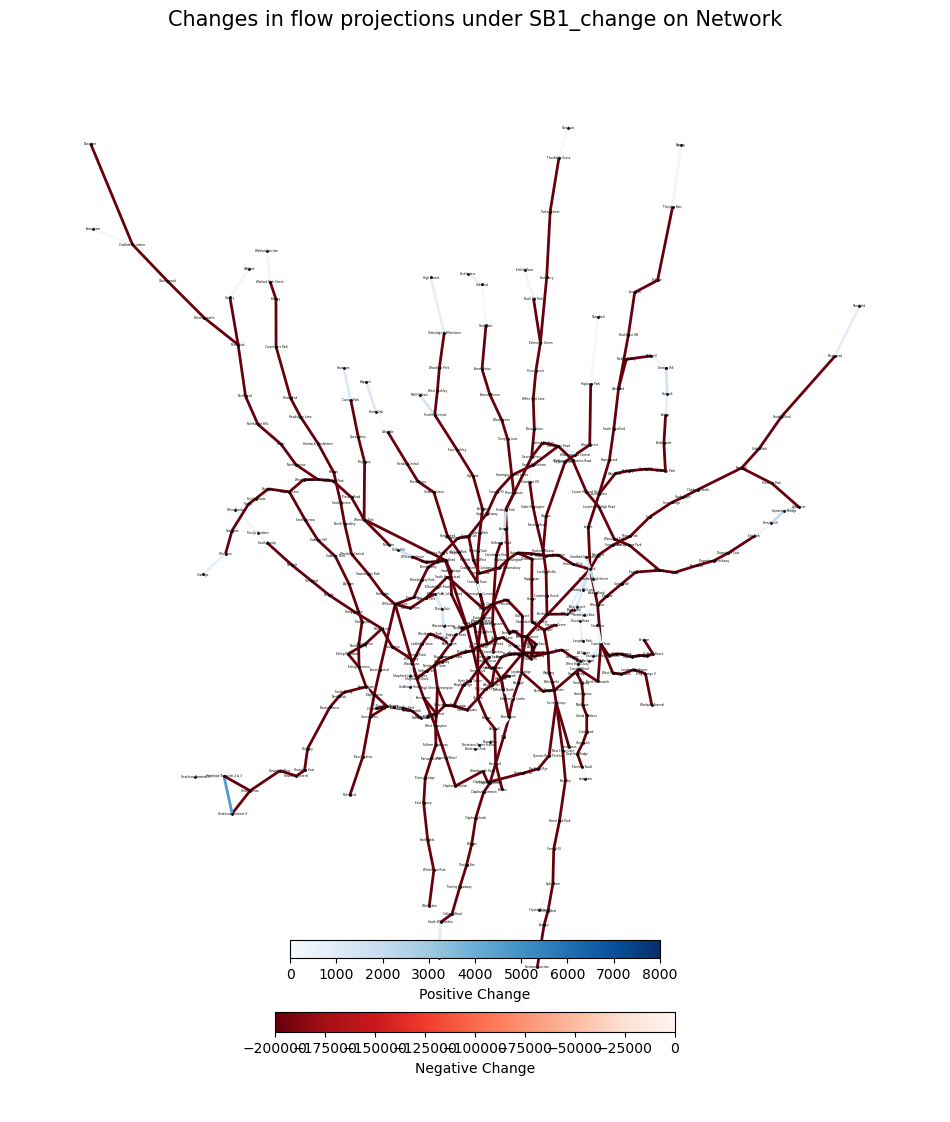

In [18]:
# 从最小到最大的颜色映射
SB1_change_values = np.array(list(SB1_change.values()))
max_change = np.max(SB1_change_values)
min_change = np.min(SB1_change_values)
positive_norm = Normalize(0, 8000)
negative_norm = Normalize(-200000, 0)

# 使用两个不同的颜色映射
positive_cmap = plt.cm.Blues
negative_cmap = plt.cm.Reds_r 

# 计算边的颜色
SB1_change_color = []
for _, _, data in G.edges(data=True):
    value = data['SB1_change']
    if value >= 0:
        color = positive_cmap(positive_norm(value))
    else:
        color = negative_cmap(-negative_norm(value))  # 取反，因为负数的norm计算可能需要调整
    SB1_change_color.append(color)

# 边的宽度
SB1_change_width = [2 for _ in G.edges()]

# 绘制网络图
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color=SB1_change_color, width=SB1_change_width)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=1)
nx.draw_networkx_labels(G, pos, font_size=2, font_color='black')  # 显示节点名称
# 设置颜色条
positive_sm = plt.cm.ScalarMappable(cmap=positive_cmap, norm=positive_norm)
positive_sm.set_array([])
negative_sm = plt.cm.ScalarMappable(cmap=negative_cmap, norm=negative_norm)
negative_sm.set_array([])

# 创建一个颜色条
cbar_pos = plt.colorbar(positive_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_neg = plt.colorbar(negative_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_pos.set_label('Positive Change')
cbar_neg.set_label('Negative Change')

plt.axis('off')
plt.title("Changes in flow projections under SB1_change on Network", fontsize=15)
plt.show()

In [16]:
#create a dictionary to store flows for all edges
SB2_change = {(u,v): 0 for u,v in G.edges()}
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.Orig
    target = row.Dest
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            SB2_change[(u,v)] += row.SB2_change
        except:
            SB2_change[(v,u)] += row.SB2_change
#set this as a network attribute
nx.set_edge_attributes(G, SB2_change, 'SB2_change')

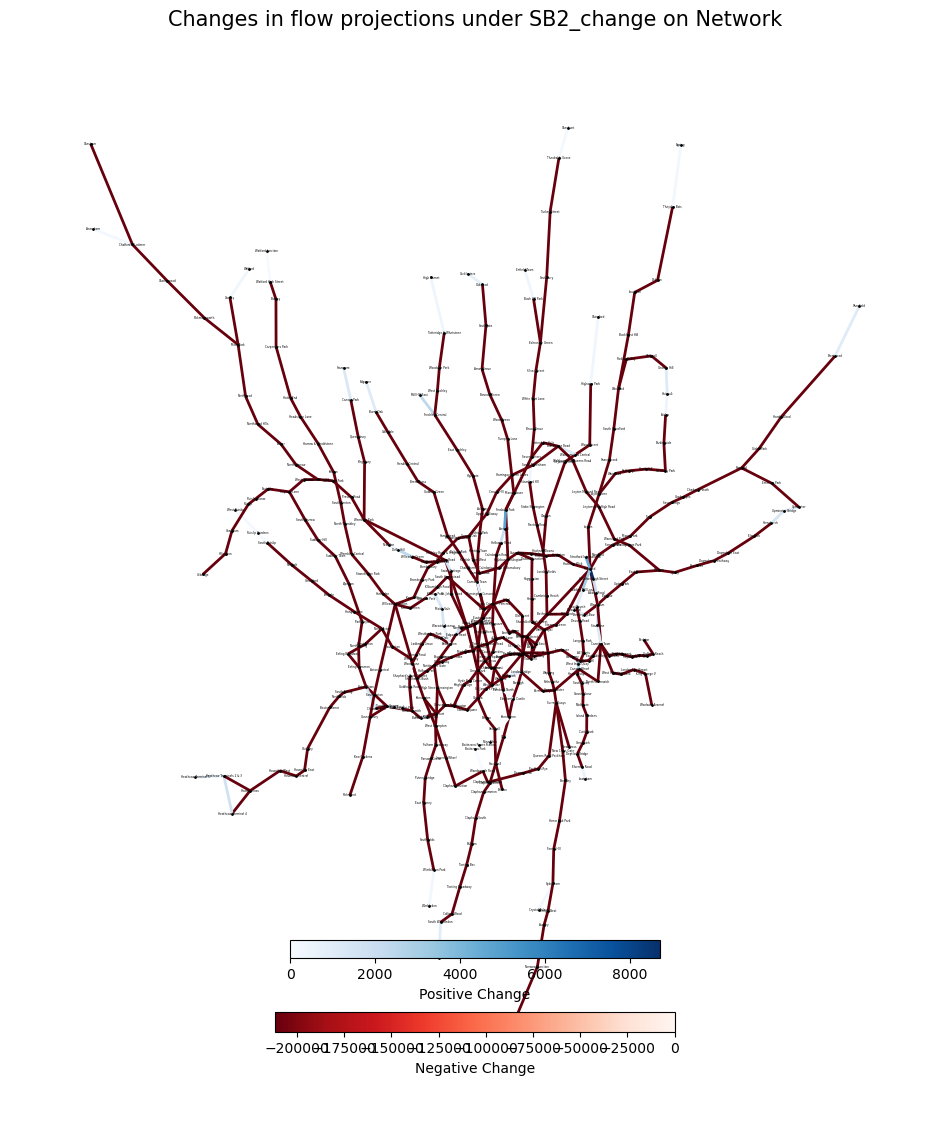

In [17]:
# 从最小到最大的颜色映射
SB2_change_values = np.array(list(SB2_change.values()))
max_change = np.max(SB2_change_values)
min_change = np.min(SB2_change_values)
positive_norm = Normalize(0, max_change)
negative_norm = Normalize(min_change, 0)

# 使用两个不同的颜色映射
positive_cmap = plt.cm.Blues
negative_cmap = plt.cm.Reds_r 

# 计算边的颜色
SB2_change_color = []
for _, _, data in G.edges(data=True):
    value = data['SB2_change']
    if value >= 0:
        color = positive_cmap(positive_norm(value))
    else:
        color = negative_cmap(-negative_norm(value))  # 取反，因为负数的norm计算可能需要调整
    SB2_change_color.append(color)

# 边的宽度
SB2_change_width = [2 for _ in G.edges()]

# 绘制网络图
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color=SB2_change_color, width=SB2_change_width)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=1)
nx.draw_networkx_labels(G, pos, font_size=2, font_color='black')  # 显示节点名称
# 设置颜色条
positive_sm = plt.cm.ScalarMappable(cmap=positive_cmap, norm=positive_norm)
positive_sm.set_array([])
negative_sm = plt.cm.ScalarMappable(cmap=negative_cmap, norm=negative_norm)
negative_sm.set_array([])

# 创建一个颜色条
cbar_pos = plt.colorbar(positive_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_neg = plt.colorbar(negative_sm, ax=ax, orientation='horizontal', shrink=0.5, pad=-0.1, fraction=0.02)
cbar_pos.set_label('Positive Change')
cbar_neg.set_label('Negative Change')

plt.axis('off')
plt.title("Changes in flow projections under SB2_change on Network", fontsize=15)
plt.show()